In [1]:
%load_ext autoreload
%autoreload 2
%env ANYWIDGET_HMR=1

env: ANYWIDGET_HMR=1


In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import zarr
import celldega as dega
from matplotlib.colors import to_hex
print(dega.pre.__file__)

technology = 'Xenium'

/Users/whuan/opt/anaconda3/envs/celldega_env/lib/python3.9/site-packages/anywidget/_util.py:261: UserWarning: anywidget: Live-reloading feature is disabled. To enable, please install the 'watchfiles' package.
  start_thread=_should_start_thread(path),


/Users/whuan/dev/celldega/src/celldega/pre/__init__.py


In [3]:
sample = '2024_xenium_breast_htma'

DATA_DIR = f'/Users/whuan/dev/ist_benchmarking/data'

data_dir = f'{DATA_DIR}/{sample}'
path_landscape_files = f'{DATA_DIR}/landscapes/{sample}'

for folder in [data_dir, path_landscape_files]:
    if not os.path.exists(folder):
        os.mkdir(folder)
        print (folder)

# Copy data

In [4]:
raw_data_bucket = 'fc-b8e703d3-de2d-4532-94cc-efe864b4feea/SPARC/Revisions/20240430__200116__SPARC_Revisions_JN30APR24/output-XETG00212__0018231__Region_1__20240430__200125'

for file in [
    'morphology_focus/morphology_focus_0000.ome.tif',
    'cells.zarr',
    'cells.csv',
    'cells.csv.gz',
    'cells.parquet',
    'transcripts.parquet',
    'cell_boundaries.parquet',
    ]:

    if os.path.exists(f"{data_dir}/{file.split('/')[-1]}"):
        print (f'{file} is previously downloaded')
    else:
        print (f'{file} not found')
        cmd = f'gsutil cp gs://{raw_data_bucket}/{file} {data_dir}/'
        print (cmd)
        # ! {cmd}


for folder in [
    'cell_feature_matrix',
    'analysis',
    ]:

    if os.path.exists(f"{data_dir}/{folder}"):
        print (f'{folder} is previously downloaded')
    else:
        print (f'{folder} not found')
        cmd = f'gsutil cp -r gs://{raw_data_bucket}/{folder} {data_dir}/'
        print (cmd)
        # ! {cmd}

morphology_focus/morphology_focus_0000.ome.tif is previously downloaded
cells.zarr is previously downloaded
cells.csv is previously downloaded
cells.csv.gz is previously downloaded
cells.parquet is previously downloaded
transcripts.parquet is previously downloaded
cell_boundaries.parquet is previously downloaded
cell_feature_matrix is previously downloaded
analysis is previously downloaded


In [5]:
path_transformation_matrix = f'{path_landscape_files}/xenium_transform.csv'
path_meta_cell_micron = f'{data_dir}/cells.csv.gz'
path_meta_cell_image = f'{path_landscape_files}/cell_metadata.parquet'

# CBG

In [6]:
cbg = dega.pre.read_cbg_mtx(f"{data_dir}/cell_feature_matrix")
meta_gene_exp = dega.pre.calc_meta_gene_data(cbg)

Reading mtx file from  /Users/whuan/dev/ist_benchmarking/data/2024_xenium_breast_htma/cell_feature_matrix
cbg is a dense DataFrame. Proceeding with dense operations.
Calculating mean expression
Calculating variance


/Users/whuan/dev/celldega/src/celldega/pre/landscape.py:72: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, 1, 4]'. Picking the first and converting the rest.
  variance = ((cbg - mean_expression) ** 2).sum(axis=0) / num_tiles


Calculating maximum expression
Calculating proportion of non-zero expression


# Gene metadata

In [12]:
path_cbg = f"{data_dir}/cell_feature_matrix"
path_output = f"{path_landscape_files}/meta_gene.parquet"
dega.pre.make_meta_gene('Xenium', path_cbg, path_output)

Reading mtx file from  /Users/whuan/dev/ist_benchmarking/data/2024_xenium_breast_htma/cell_feature_matrix
cbg is a dense DataFrame. Proceeding with dense operations.
Calculating mean expression
Calculating variance


/Users/whuan/dev/celldega/src/celldega/pre/landscape.py:72: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, 1, 4]'. Picking the first and converting the rest.
  variance = ((cbg - mean_expression) ** 2).sum(axis=0) / num_tiles


Calculating maximum expression
Calculating proportion of non-zero expression


# Create cell by gene files

In [13]:
dega.pre.save_cbg_gene_parquets(path_landscape_files, cbg, verbose=True)

Processing gene 0: ABCC11
Processing gene 100: FAM107B
Processing gene 200: PLD4
Processing gene 300: NegControlCodeword_0500
Processing gene 400: UnassignedCodeword_0359
Processing gene 500: UnassignedCodeword_0459


# Image tiles

In [39]:
image_scale = 1
file_path = f"{data_dir}/morphology_focus_0000.ome.tif"
img = imread(file_path)[...,0]
img_8bit = dega.pre.check_and_convert_16_to_8_bit(img)
dega.pre.make_deepzoom_pyramid(img_8bit, f"{path_landscape_files}/pyramid_images", 'dapi', clahe_tile_size=32, clahe_contrast_limit=60, suffix=".webp[Q=100]")

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series failed to read 'morphology_focus_0001.ome.tif', raised FileNotFoundError(2, 'No such file or directory'). Missing data are zeroed
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series failed to read 3 files


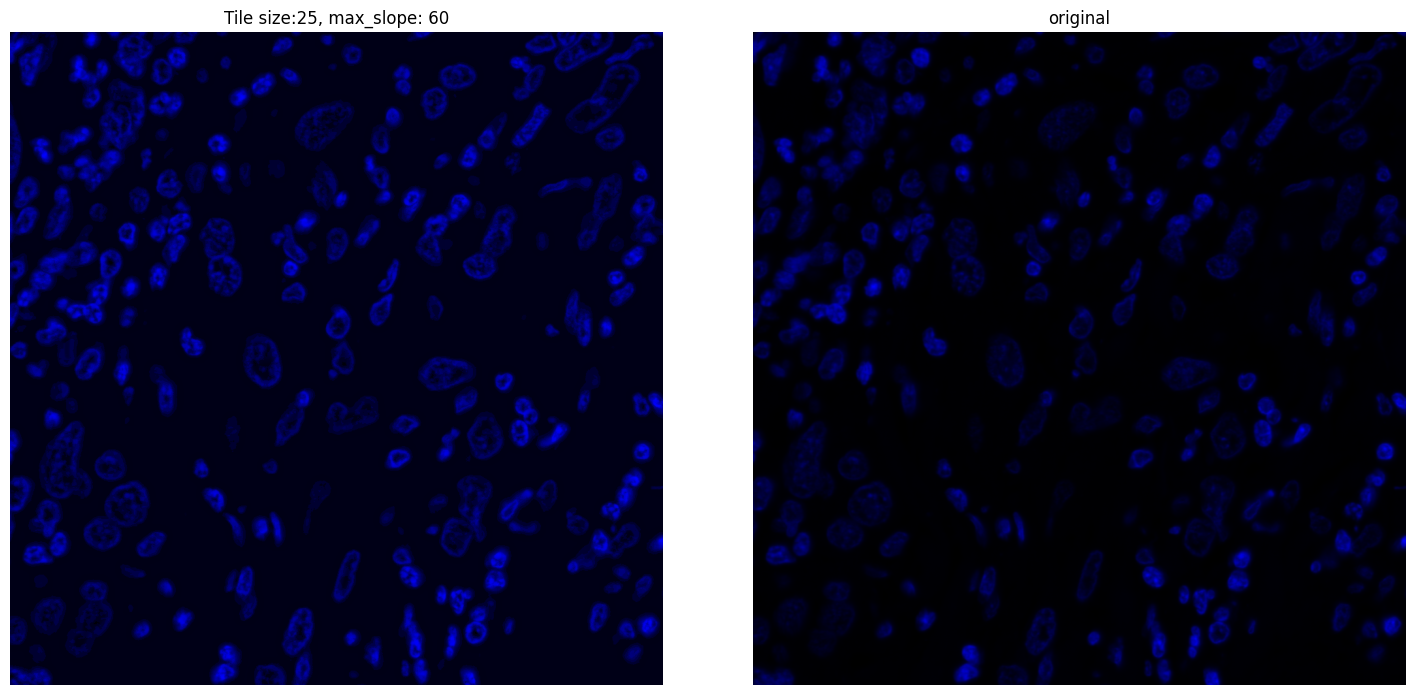

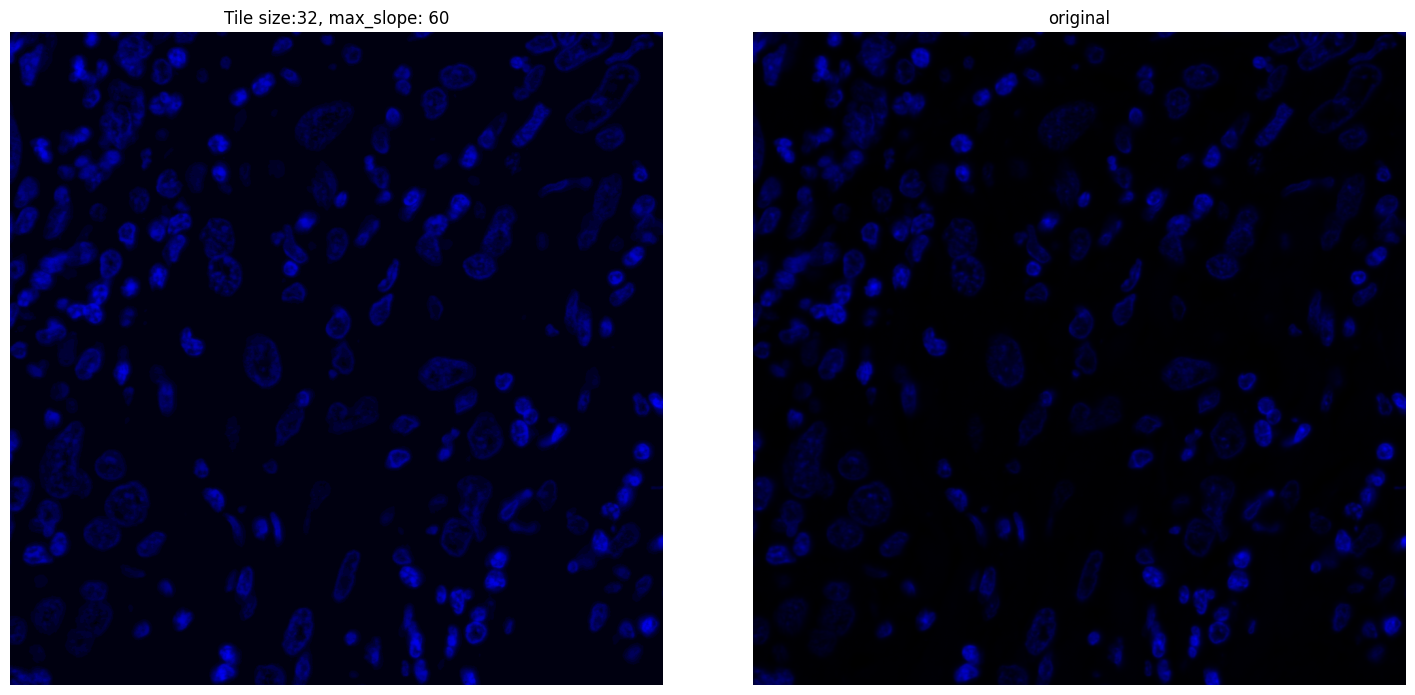

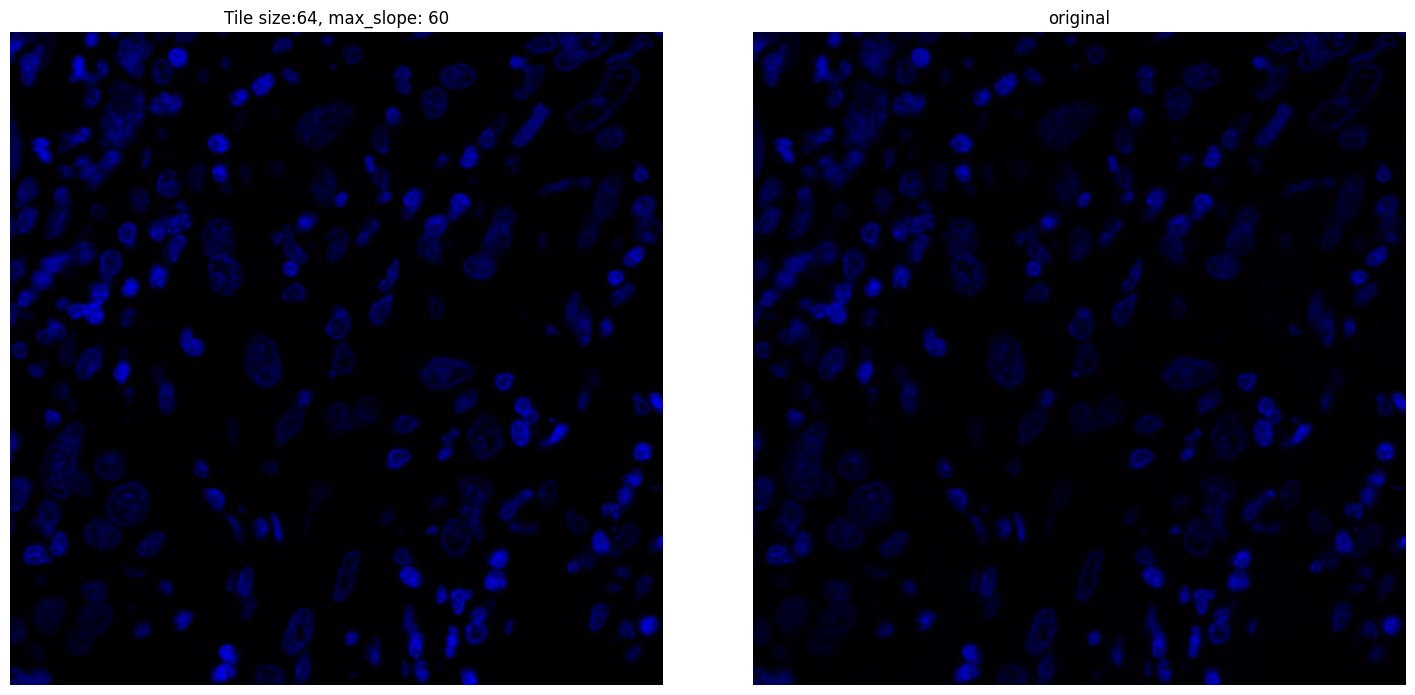

In [41]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pyvips

# Define a custom colormap that transitions from black to blue
black_to_blue = LinearSegmentedColormap.from_list("black_to_blue", ["black", "blue"])

start = 35000
size = 500
method='clahe'

img_original = np.ascontiguousarray(img[start-size:start+size, start-size:start+size])
img_8bit = dega.pre.check_and_convert_16_to_8_bit(img_original)
img_test = img_8bit

width, height = img_test.shape
image = pyvips.Image.new_from_memory(img_test, height, width, 1, format="uchar")
for clahe_tile_size in [25, 32, 64]:
    for clip in [60]:
        # Apply CLAHE using hist_local
        clahe_image = image.hist_local(clahe_tile_size, clahe_tile_size, max_slope=int(clip))
        clahe_image.write_to_file(f"test.png")
        img_clahe_test = imread(f"test.png")


        # Create a figure with 1 row and 2 columns for side-by-side images
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        # Display img_transformed on the first subplot
        axes[0].imshow(img_clahe_test, cmap=black_to_blue)
        axes[0].axis('off')  # Turn off the axis for a cleaner look
        axes[0].set_title(f"Tile size:{clahe_tile_size}, max_slope: {clip}")


        # Display img_subset on the second subplot
        axes[1].imshow(img_original, cmap=black_to_blue)
        axes[1].axis('off')  # Turn off the axis for a cleaner look
        axes[1].set_title('original')

        # Display the figure
        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()
        
        

# Cell meta

In [18]:
# Function to open a Zarr file
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r")
    if path.endswith(".zip")
    else zarr.DirectoryStore(path)
    )
    return zarr.group(store=store)

# For example, use the above function to open the cells Zarr file, which contains segmentation mask Zarr arrays
root = open_zarr(f"{data_dir}/cells.zarr.zip")
transformation_matrix = root['masks']['homogeneous_transform'][:]
transformation_matrix


array([[4.705882, 0.      , 0.      , 0.      ],
       [0.      , 4.705882, 0.      , 0.      ],
       [0.      , 0.      , 1.      , 0.      ],
       [0.      , 0.      , 0.      , 1.      ]], dtype=float32)

In [19]:
pd.DataFrame(transformation_matrix[:3,:3]).to_csv(
    f'{path_landscape_files}/xenium_transform.csv', 
    sep=' ', 
    header=False, 
    index=False
)

path_transformation_matrix = f'{path_landscape_files}/xenium_transform.csv'
path_meta_cell_micron = f'{data_dir}/cells.csv.gz'
path_meta_cell_image = f'{path_landscape_files}/cell_metadata.parquet'

default_clustering = pd.read_csv(f'{data_dir}/analysis/clustering/gene_expression_graphclust/clusters.csv', index_col=0)

In [20]:
dega.pre.make_meta_cell_image_coord(
    'Xenium', 
    path_transformation_matrix, 
    path_meta_cell_micron, 
    path_meta_cell_image, 
    image_scale=1
)

# Save default clusters

In [21]:
if not os.path.exists(f'{path_landscape_files}/cell_clusters/'):
    os.mkdir(f'{path_landscape_files}/cell_clusters/')

default_clustering = pd.DataFrame(default_clustering.values, index=default_clustering.index.tolist(), columns=['cluster'])
default_clustering_ini = pd.DataFrame(default_clustering.values, index=default_clustering.index.tolist(), columns=['cluster'])
meta_cell = pd.read_parquet(f'{path_landscape_files}/cell_metadata.parquet')
default_clustering_ini['cluster'] = default_clustering_ini['cluster'].astype('string')
default_clustering = pd.DataFrame(index=meta_cell.index.tolist())
default_clustering.loc[default_clustering_ini.index.tolist(), 'cluster'] = default_clustering_ini['cluster']
default_clustering.to_parquet(f'{path_landscape_files}/cell_clusters/cluster.parquet')

# Cluster color

In [22]:
ser_counts = default_clustering['cluster'].value_counts()
clusters = ser_counts.index.tolist()

# Get all categorical color palettes from Matplotlib and flatten them into a single list of colors
palettes = [plt.get_cmap(name).colors for name in plt.colormaps() if "tab" in name]
flat_colors = [color for palette in palettes for color in palette]

# Convert RGB tuples to hex codes
flat_colors_hex = [to_hex(color) for color in flat_colors]

# Use modular arithmetic to assign a color to each gene, white for genes with "Blank"
colors = [
    flat_colors_hex[i % len(flat_colors_hex)] if "Blank" not in cluster else "#FFFFFF"
    for i, cluster in enumerate(clusters)
]

# Create a DataFrame with genes and their assigned colors
ser_color = pd.Series(colors, index=clusters, name='color')
meta_cluster = pd.DataFrame(ser_color)
meta_cluster['count'] = ser_counts
meta_cluster.to_parquet(f'{path_landscape_files}/cell_clusters/meta_cluster.parquet')

# Transcripts

In [23]:
technology = 'Xenium'
path_trx = f'{data_dir}/transcripts.parquet'
path_trx_tiles = f'{path_landscape_files}/transcript_tiles'

In [24]:
# Start timer
start_time = time.time()

tile_bounds = dega.pre.make_trx_tiles(
        technology,
        path_trx,
        path_transformation_matrix,
        path_trx_tiles,
        coarse_tile_size=5000,
        fine_tile_size=250,
        chunk_size=100000,
        verbose=False,
        image_scale=1,
        max_workers=4)
        
# End timer
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds\n")

Processing chunks: 100%|██████████| 512/512 [00:01<00:00, 409.21it/s]
Processing coarse tiles: 220tile [06:35,  1.80s/tile]

Runtime: 403.02 seconds



# Boundaries

In [25]:
tile_size = 250

path_cell_boundaries = f'{data_dir}/cell_boundaries.parquet'
path_output = f'{path_landscape_files}/cell_segmentation'


# Start timer
start_time = time.time()


dega.pre.make_cell_boundary_tiles(
    'Xenium',
    path_cell_boundaries,
    path_meta_cell_micron,
    path_transformation_matrix,
    path_output,
    coarse_tile_size=5000,
    fine_tile_size=250,
    tile_bounds=tile_bounds,
    image_scale=1,
    max_workers=8)


# End timer
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds\n")

Processing coarse tiles: 100%|██████████| 11/11 [04:15<00:00, 23.21s/it]


Runtime: 368.28 seconds



# Gene metadata

In [26]:
path_cbg = f'{data_dir}/cell_feature_matrix/'
path_output = f'{path_landscape_files}/gene_metadata.parquet'
dega.pre.make_meta_gene('Xenium', path_cbg, path_output)

Reading mtx file from  /Users/whuan/dev/ist_benchmarking/data/2024_xenium_breast_htma/cell_feature_matrix/
cbg is a dense DataFrame. Proceeding with dense operations.
Calculating mean expression
Calculating variance


/Users/whuan/dev/celldega/src/celldega/pre/landscape.py:72: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, 1, 4]'. Picking the first and converting the rest.
  variance = ((cbg - mean_expression) ** 2).sum(axis=0) / num_tiles


Calculating maximum expression
Calculating proportion of non-zero expression


# Max zoom

In [27]:
# Example usage:
path_image_pyramid = f'{path_landscape_files}/pyramid_images/dapi_files/'  # Change this to your actual directory path
max_pyramid_zoom = dega.pre.get_max_zoom_level(path_image_pyramid)

print(max_pyramid_zoom)

17


# Cluster gene expression

In [28]:
usecols = ['cell_id', 'x_centroid', 'y_centroid']
meta_cell = pd.read_csv(f'{data_dir}/cells.csv.gz', index_col=0, usecols=usecols)
meta_cell.columns = ['center_x', 'center_y']
df_meta = pd.read_csv(f'{data_dir}/analysis/clustering/gene_expression_graphclust/clusters.csv', index_col=0)
df_meta['Cluster'] = df_meta['Cluster'].astype('string')
df_meta.columns = ['cluster']
meta_cell['cluster'] = df_meta['cluster']

list_ser = []
for inst_cat in meta_cell['cluster'].unique().tolist():
    if inst_cat is not None:
        inst_cells = meta_cell[meta_cell['cluster'] == inst_cat].index.tolist()
        # print(inst_cat, len(inst_cells))

        inst_ser = cbg.loc[inst_cells].sum()/len(inst_cells)
        inst_ser.name = inst_cat

        list_ser.append(inst_ser)

df_sig = pd.concat(list_ser, axis=1)
# handling weird behavior where there is a multiindex it appears
df_sig.columns = df_sig.columns.tolist()
df_sig.index = df_sig.index.tolist()

keep_genes = df_sig.index.tolist()
keep_genes = [x for x in keep_genes if 'Unassigned' not in x]
keep_genes = [x for x in keep_genes if 'NegControl' not in x]
keep_genes = [x for x in keep_genes if 'DeprecatedCodeword' not in x]

df_sig = df_sig.loc[keep_genes, clusters]
df_sig.sparse.to_dense().to_parquet(f'{path_landscape_files}/df_sig.parquet')

# Save Landscape Parameters JSON

In [29]:
image_info =  [
        {
            "name": "dapi",
            "button_name": "DAPI",
            "color": [
                0,
                0,
                255
            ]
        }
    ]

dega.pre.save_landscape_parameters(
    'Xenium', 
    path_landscape_files,
    'dapi_files',
    tile_size=tile_size,
    image_info=image_info,
    image_format='.webp'
)

/Users/whuan/dev/ist_benchmarking/data/landscapes/2024_xenium_breast_htma/pyramid_images/dapi_files
